# Apache log n-gram analysis

### Data Dictionary
Using additional analysis not shown earlier, I was able to come up with this data dictionary to describe the contents of the data file.

 | Column     | Description |
 |------------|:-----------:|
 | host       | The hostname or IP address making the request to the website |
 | logname    | not a populated field |
 | time       | integer version of unix timestamp |
 | method     | HTTP method for the call |
 | url        | path to the file being requested |
 | response   | HTTP response code for the call |
 | bytes      | Number of bytes returned for the request |
 | referer    | not a populated field |
 | useragent  | not a populated field |

---

### Prerequisites for Python Notebook
 - python 3.x
 - python packages
   - pip3 install pandas
   - pip3 install scikit-learn
   - pip3 install matplotlib
   - pip3 install networkx
 - jupyter notebook --debug > log.file 2>&1
 
### Sample data used for analysis
- http://indeedeng.github.io/imhotep/files/nasa_19950801.tsv (saved in 'rawData/nasa_19950801.tsv')
- http://indeedeng.github.io/imhotep/files/nasa_19950630.22-19950728.12.tsv.gz
- http://indeedeng.github.io/imhotep/files/nasa_19950731.22-19950831.22.tsv.gz

### Import necessary libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
import hashlib 
import networkx as nx


### Read data file

In [9]:
apache_log_path = 'rawData/nasa_19950801.tsv'
apache_log_data = pd.read_csv(apache_log_path, sep='\t', header=0)

### Extract navigation path for most active user
This was found earlier to be 'edams.ksc.nasa.gov'. We've hard-coded that value here.

In [10]:
visitor_address = apache_log_data.host
histogram_visitor_address = visitor_address.value_counts()
single_user_logs = apache_log_data.loc[apache_log_data['host'] == 'edams.ksc.nasa.gov']
single_user_path = single_user_logs['url']

### Create bi-gram of the single user's path for the purposes of generating a directed graph
We have our own home-grown function to create n-grams that needs a bit of work to be 100% accurate, but it will server our needs for now. The 'tuple' version is for graphing and the 'dataframe' version is to make it a bit easier to read in column form.

In [11]:
#should unwind this a bit to make the purpose more clear
#also, there should be padding added to the front/back to indicate beginning and ending of a path
def find_ngrams(input_list, n):
  return [list(x) for x in set(tuple(x) for x in list(zip(*[input_list[i:] for i in range(n)])))]

single_user_path_bi_gram_as_tuples = list(find_ngrams(single_user_path,2))
labels=["vertex1","vertex2"]
single_user_path_bi_gram_as_dataframe = pd.DataFrame.from_records(single_user_path_bi_gram_as_tuples, columns=labels)
print(single_user_path_bi_gram_as_dataframe)

                         vertex1                       vertex2
0                      /ksc.html                     /ksc.html
1     /images/NASA-logosmall.gif  /images/MOSAIC-logosmall.gif
2     /images/ksclogo-medium.gif  /images/MOSAIC-logosmall.gif
3     /images/ksclogo-medium.gif    /images/NASA-logosmall.gif
4    /images/WORLD-logosmall.gif                     /ksc.html
5                 /htbin/wais.pl                     /ksc.html
6                      /ksc.html    /images/NASA-logosmall.gif
7     /images/NASA-logosmall.gif    /images/ksclogo-medium.gif
8    /images/WORLD-logosmall.gif    /images/NASA-logosmall.gif
9   /images/MOSAIC-logosmall.gif     /images/USA-logosmall.gif
10                  /\\yahoo.com                     /ksc.html
11   /images/WORLD-logosmall.gif                /htbin/wais.pl
12                     /ksc.html    /images/ksclogo-medium.gif
13   /images/WORLD-logosmall.gif                  /\\yahoo.com
14     /images/USA-logosmall.gif   /images/WORLD-logosm

### Single User's Path Through the Site Converted to a Directed Graph
We take the bi-grams (in tuple form) and feed it into our graphing method.

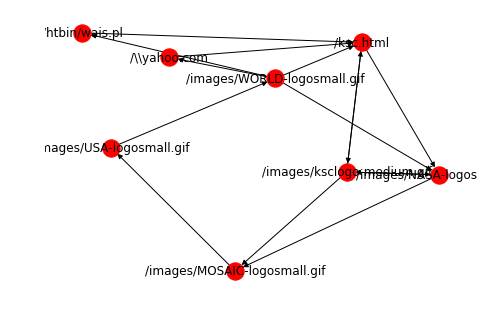

In [12]:
most_active_user_graph = nx.DiGraph()
most_active_user_graph.add_edges_from(single_user_path_bi_gram_as_tuples)
nx.draw(most_active_user_graph, arrows=True, with_labels=True)

### Now, let's look at the graph for the second most active user
We see from earlier analysis (not listed here) that it's the IP address '130.110.74.81'

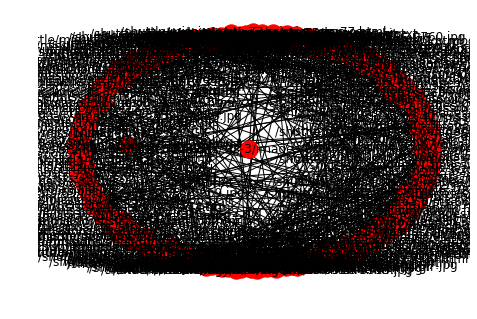

In [15]:
#get just the entries from the second most active user
second_most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == '130.110.74.81']
#get a list of just the URLs for that user
second_most_active_user_path = second_most_active_user_logs['url']
#fix the set of nodes in the same order
second_most_active_user_nodes = set(second_most_active_user_path)
#the initial positioning was found by running the next two lines and hard-coding the values.
fixed_node_positions = nx.spring_layout(second_most_active_user_nodes, iterations=100)
#print(fixed_node_positions)
#fixed_node_positions = {'/images/WORLD-logosmall.gif': [-0.56042567, -0.89567039], '/images/MOSAIC-logosmall.gif': [ 0.83801216, -0.50295322], '/htbin/wais.pl': [0.50398009, 0.90729381], '/ksc.html': [-0.18635479,  0.83881586], '/images/ksclogo-medium.gif': [-0.98550404, -0.21915963], '/images/USA-logosmall.gif': [ 0.21988551, -0.96885458], '/\\\\yahoo.com':[1.        , 0.25469367], '/images/NASA-logosmall.gif': [-0.82959325,  0.58583448]}
#create bi-gram for graph
second_most_active_user_path_bi_gram = list(find_ngrams(second_most_active_user_path,2))
#generate graph with persistent node locations
second_most_active_user_graph = nx.DiGraph()
second_most_active_user_graph.add_edges_from(second_most_active_user_path_bi_gram)
nx.draw(second_most_active_user_graph, fixed_node_positions, arrows=True, with_labels=True)

### Let's look at the generic case. 
We can get the graph by setting the index of the histogram table (choose an index less than 2365)

ppp2_084.bekkoame.or.jp


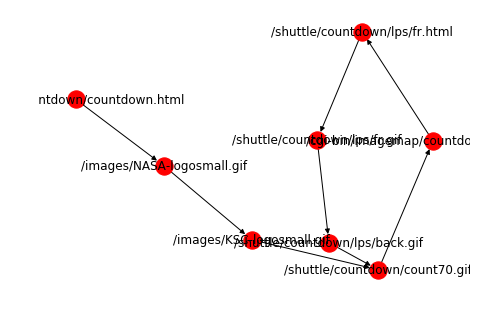

In [21]:
index_to_graph = 1000

visitor_addresses = apache_log_data.host
histogram_visitor_address = visitor_addresses.value_counts()
visitor_address = histogram_visitor_address.index[index_to_graph]
print(visitor_address)

#get just the entries from the second most active user
nth_most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == visitor_address]
#get a list of just the URLs for that user
nth_most_active_user_path = nth_most_active_user_logs['url']

#create bi-gram for graph
nth_most_active_user_path_bi_gram = list(find_ngrams(nth_most_active_user_path,2))
#generate graph with persistent node locations
nth_most_active_user_graph = nx.DiGraph()
nth_most_active_user_graph.add_edges_from(nth_most_active_user_path_bi_gram)
nx.draw(nth_most_active_user_graph,  arrows=True, with_labels=True)
